<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

In [1]:
#install node2vec with conda / pip
!pip install node2vec
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from node2vec import Node2Vec

<html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

File contains duplicate edges:  False


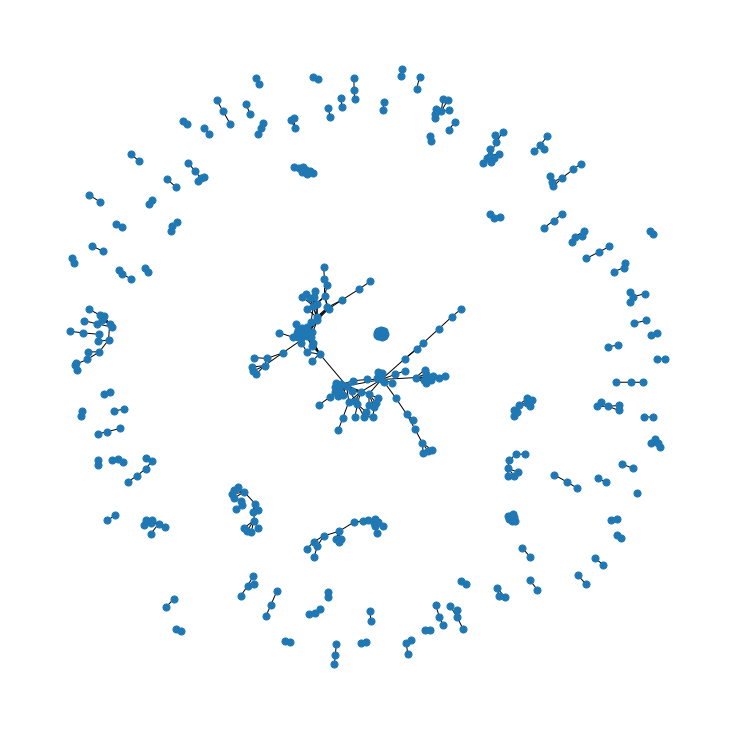

In [3]:
#Στην ιστοσελιδα αναφέρεται πως δεν υπαρχουν διπλοτυπα των ακμων με ιδια ή αντιαστροφη σειρά (The network is undirected and does not contain multiple edges)
#αλλα θα το ελέγξω καλου κακου
def file_contains_duplicate_edges():
    edges = set()
    contains_duplicates = False
    duplicates = set()
    with open("out.dbpedia-similar", 'r') as f:
        for line in f:
            if line.startswith("%"):
                continue

            a, b = [int(i) for i in line.split()]
            if (a, b) in edges or (b, a) in edges:
                contains_duplicates = True
                duplicates.add((a, b))
            else:
                edges.add((a, b))
    return contains_duplicates, duplicates

contains_duplicates, duplicates_set = file_contains_duplicate_edges()
print("File contains duplicate edges: ", contains_duplicates)
G = nx.read_edgelist('out.dbpedia-similar', create_using = nx.Graph(), nodetype = int, comments='%')
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(10,10))
nx.draw(G, node_size=50)
plt.show()

 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [4]:
initial_node_count = G.number_of_nodes()
initial_edges_count = G.number_of_edges() #uncomment and complete
initial_average_degree = np.mean(list(dict(G.degree).values()))
initial_connected_components = nx.number_connected_components(G) #uncomment and complete

print(" Initial_node_count = ", G.number_of_nodes(),
"\n Initial_edges_count = ", G.number_of_edges(),
"\n Initial_average_degree = ", np.mean(list(dict(G.degree).values())),
"\n Initial_connected_components = ", nx.number_connected_components(G))

 Initial_node_count =  430 
 Initial_edges_count =  564 
 Initial_average_degree =  2.6232558139534885 
 Initial_connected_components =  95


<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [5]:
%pip install 'scipy>=1.8'
%pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
def unconnected_node_pairs(g):
  unconnected_pairs = []
  adj_matrix = nx.adjacency_matrix(g, nodelist=range(1, initial_node_count + 1))
  for r in range(initial_node_count - 1):
      for c in range(r + 1, initial_node_count):
          if adj_matrix.A[r][c] == 0:
              unconnected_pairs.append((r + 1, c + 1))
  return set(tuple(unconnected_pairs))
unconnected = unconnected_node_pairs(G)
print('Number of unconnected pairs : ',len(unconnected))

Number of unconnected pairs :  91671


<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [7]:
#check splitting and number of nodes
def removable_edges(g):
    temp = g.copy()
    removable = []
    for u,v in g.edges:
        temp.remove_edge(u,v)
        if nx.number_connected_components(temp) == nx.number_connected_components(g):
            removable.append((u, v))
        else:
            temp.add_edge(u,v)
    return set(tuple(removable))
#if ( == initial_connected_components) and ( == initial_node_count): #uncomment and complete (modifications allowed)
#το κανω συναρτησιακα αρα αντι για το initial connected components βαζω την nx συναρτηση
removable = removable_edges(G)
print("The number of removable edges are: ", len(removable))

The number of removable edges are:  229


<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [8]:
assert removable.isdisjoint(unconnected), "Removable edges and Unconnected pairs should be disjoint but are not."

In [9]:
#dataframe of removable edges (they will function as positive samples)
removable_edges_df = pd.DataFrame(data={"edges": sorted(removable), "link": [1] * len(removable)})  #uncomment and complete

#dataframe of unconnected node pairs (they will function as negative samples)
unconnected_pairs_df = pd.DataFrame(data={"edges": sorted(unconnected), "link": [0] * len(unconnected)})# uncomment and complete

#merge in one dataframe
unconnected_removable_edges = unconnected_pairs_df.append(removable_edges_df,ignore_index=True)
unconnected_removable_edges
#build graph G'=G_reduced


,edges,link
0,"(1, 6)",0
1,"(1, 7)",0
2,"(1, 8)",0
3,"(1, 9)",0
4,"(1, 10)",0
...,...,...
91895,"(401, 403)",1
91896,"(401, 404)",1
91897,"(402, 403)",1
91898,"(402, 404)",1


In [10]:
#1(vβ) build graph G'=G_reduced
G_reduced = G.copy()
G_reduced.remove_edges_from(removable)

#1(vγ)
new_node_count = G_reduced.number_of_nodes()
new_edges_count = G_reduced.number_of_edges() #uncomment and complete
new_average_degree = np.mean(list(dict(G_reduced.degree).values()))
new_connected_components = nx.number_connected_components(G_reduced) #uncomment and complete

print(" New_node_count = ", G_reduced.number_of_nodes(),
"\n New_edges_count = ", G_reduced.number_of_edges(),
"\n New_average_degree = ", np.mean(list(dict(G_reduced.degree).values())),
"\n New_connected_components = ", nx.number_connected_components(G))

 New_node_count =  430 
 New_edges_count =  335 
 New_average_degree =  1.558139534883721 
 New_connected_components =  95


<html><font size=4><B>2. Εισαγωγή σε similarity-based μετρικές για Link prediction</B></font><BR><BR>
     <li> Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  <B></B>
        <li> Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li>
        <li> Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.</li><BR><BR>
    <li><B>2(i).</B> Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.<a></u> <BR><BR>
    <li><B>2(ii). </B>Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)</li><BR>
    <li><B>2(iii). </B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

In [11]:
import seaborn as sns
k = 7 #k = Α.Μ. mod 10 
#2(i).
JC_list = list(nx.jaccard_coefficient(G_reduced))
#print(JC_list)

#2(ii).
best_JC = sorted(JC_list,key=lambda x: x[2], reverse = True)
print("The 7 first edges with the highest Jaccard Coefficient are: ")
for i in range(0,k):
  print(best_JC[i])

print('\n')

def JCfunction(threshold_jc):   #uncomment and complete
  #2(iii).
  #print('For threshold', threshold_jc, ':\n')
  pos = []
  neg = []
  true_positive = 0
  true_negative = 0
  false_pos = 0
  false_neg = 0
  for i in JC_list:
    #Οταν εβαζα τα i[0] και i[1] μονο, μου εβγαζε 2 περισσοτερα true negative + false positive απ'ότι θα πρεπε
    if i[2] >= threshold_jc:
      pos.append((i[0],i[1]))
      if (i[0], i[1]) in removable or (i[1], i[0]) in removable:
          true_positive += 1
      elif (i[0], i[1]) not in removable and (i[1], i[0]) not in removable:
          false_pos += 1
    else:
      neg.append((i[0],i[1]))
      if (i[0], i[1]) in unconnected or (i[1], i[0]) in unconnected:
          true_negative += 1
      elif (i[0], i[1]) not in unconnected or (i[1], i[0]) not in unconnected:
          false_neg += 1


  if(true_negative+false_pos!=len(unconnected)):
      print('The sum of True Negatives +False Positives is: '+str(true_negative+false_pos)+', while it should be: '+str(len(unconnected)))
      return 0, 0 ,0 
  else:
      
      recall_jc = true_positive / (true_positive+false_neg)
      precision_jc = true_positive / (true_positive+false_pos)
      accuracy_jc = (true_positive+true_negative) / (true_positive+false_neg+true_negative+false_pos)
      return recall_jc, precision_jc, accuracy_jc; #uncomment and complete
metrics = []

metrics = []
for threshold in [0.1, 0.15, 0.25, 0.5, 1]:
  res = JCfunction(threshold)
  metrics.append({"recall": res[0],"precission": res[1],"accuracy": res[2],'threshold': threshold})
metrics = pd.DataFrame(metrics)
metrics

The 7 first edges with the highest Jaccard Coefficient are: 
(4, 46, 1.0)
(4, 47, 1.0)
(4, 49, 1.0)
(23, 34, 1.0)
(27, 33, 1.0)
(46, 47, 1.0)
(46, 49, 1.0)




,recall,precission,accuracy,threshold
0,0.707424,0.320792,0.995539,0.10
1,0.689956,0.324435,0.995647,0.15
2,0.676856,0.345982,0.996007,0.25
3,0.602620,0.416918,0.996910,0.50
4,0.550218,0.510121,0.997563,1.00


Metrics of Jaccard Coefficient for different thresholds


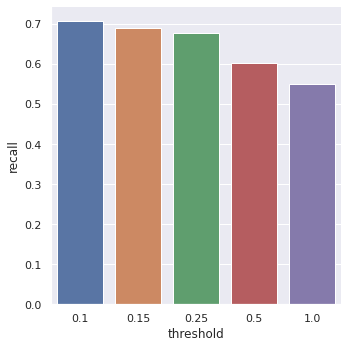

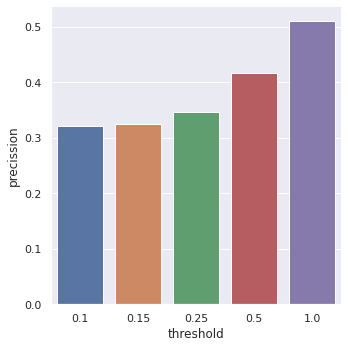

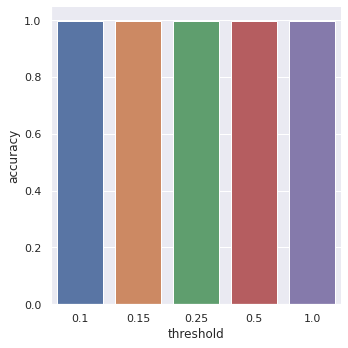

In [12]:
sns.set_theme()
print("Metrics of Jaccard Coefficient for different thresholds")
sns.catplot(data=metrics, kind = 'bar', x='threshold', y='recall')
sns.catplot(data=metrics, kind = 'bar', x='threshold', y='precission')
sns.catplot(data=metrics, kind = 'bar', x='threshold', y='accuracy')
plt.tight_layout()
plt.show()

Παρατηρούμε πως η τιμή στη μετρική accuracy είναι κοντά στο 1 ανεξάρτητα από την τιμή του threshold. Αυτό συμβαίνει διότι το σύνολο των δεδομένων είναι μη ισορροπημένο καθώς πολλά ζευγάρια κόμβων δεν συνδέονται με κάποια ακμή. Έτσι, οι μετρικές Precision και Recall είναι καλύτερες για την αξιολόγηση του ταξινομητή στην εν λόγω περίπτωση. Καθώς το JC threshold  αυξάνεται, η recall μειώνεται, ενώ η precision και η accuracy αυξάνονται. Αναμενόμενο, αφού υπάρχουν 91671 unconnected pairs (αρνητικά) και μόλις 230 removable ακμές (θετικά) (υψηλότερο όριο σημαίνει λιγότερες θετικές προβλέψεις, και αυτό μπορεί να οδηγήσει σε μικρή μείωση των αληθινών θετικών, αλλά και σε πιο σημαντική μείωση των ψευδώς θετικών, αυξάνοντας έτσι την ακρίβεια). Επίσης, υπάρχει αντίστοιχη αύξηση των ψευδώς αρνητικών με την αύξηση των αληθινών θετικών.

<html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
        <li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
     <li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

## **3(i).**
Για να βρούμε την συσχέτιση μεταξύ των τιμών των μετρικών Jaccard Coefficient, Preferential Attachment, Resource Allocation, μπορούμε να χρησιμοποιήσουμε την συνάρτηση correlate της numpy. Ως όρισμα δίνουμε τις τιμές που παίρνουν 2 από τις μετρικές σε μονοδιάστατο πίνακα (1 πίνακα για κάθε μετρική). H συνάρτηση αυτή, θεωρώντας την κάθε μια μετρική (JC, PA, RA) ως μια τυχαία μεταβλητή, επιστρέφει το κατά πόσο ένα ζεύγος μετρικών που επιλέξαμε σχετίζεται γραμμικά. Θετική τιμή correlation σημαίνει ότι όταν αυξάνεται η τιμή της μίας τυχαίας μεταβλητής, τείνει να αυξάνεται και η τιμή της άλλης. Αντίθετα, αρνητική τιμή correlation μεταξύ 2 μεταβλητών δείχνει ότι όταν η μια αυξάνεται, η άλλη μειώνεται. (Αντί για την συνάρτηση numpy.correlate, μπορούμε να χρησιμοποιήσουμε και την numpy.cov, με τα ίδια ορίσματα, η οποία επιστρέφει επίσης και την διασπορά των 2 τυχαίων μεταβλητών. Ως αποτέλεσμα δηλαδή παίρνουμε έναν πίνακα Τ(2χ2), όπου τα κελιά Τ(1,2)=Τ(2,1) = correlation των 2 μεταβλητών, ενώ τα κελιά T(1,1) και Τ(2,2) απεικονίζουν την διασπορά των μεταβλητών)

In [13]:
#replicate of the dataframe "unconnected+removables"---dataframe will be used again in (4)
ure = unconnected_removable_edges.copy()

In [14]:
#dataframe for similarity-based measurement values
ure = ure.set_index('edges')
JC = []
PA = []
RA = []
#Jaccard Coefficient
JC_list = nx.jaccard_coefficient(G_reduced)
for u,v,p in JC_list:
    JC.append(p)

#Preferential Attachment   
PA_list = nx.preferential_attachment(G_reduced)
for u,v,p in PA_list:
    PA.append(p) 
        
#Resource Allocation
RA_list = nx.resource_allocation_index(G_reduced)
for u,v,p in RA_list:
    RA.append(p)
    


# add columns
ure['Jaccad Coefficient'] = JC
ure['Preferential Attachment'] = PA
ure['Resource Allocation'] = RA

ure


,link,Jaccad Coefficient,Preferential Attachment,Resource Allocation
edges,,,,
"(1, 6)",0,0.0,1,0.0
"(1, 7)",0,0.0,2,0.0
"(1, 8)",0,0.0,1,0.0
"(1, 9)",0,0.0,7,0.0
"(1, 10)",0,0.0,1,0.0
...,...,...,...,...
"(401, 403)",1,0.0,1,0.0
"(401, 404)",1,0.0,2,0.0
"(402, 403)",1,0.0,1,0.0


<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [15]:
#uncomment whole cell
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
k = 7
X = ure[ure.columns.drop('link')] #features, uncomment and complete
y = ure['link'] #target, uncomment and complete

X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 0) #uncomment and complete
# print(X.shape)
# print(y.shape)

In [16]:
#uncomment whole cell
classifier = RandomForestClassifier()   

from sklearn.preprocessing import MinMaxScaler 
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
model = GridSearchCV(classifier, param_grid = parameters) 

In [17]:
model.fit(X_train_scaled, y_train )#train the model, uncomment and complete

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [18]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test_scaled)       #uncomment
print("My first 7 predictions are: ",predictions[:7]) #get (A.M. last digit) first predictions, uncomment and complete
print("The accuracy score of the model is:", accuracy_score(y_test, predictions))

My first 7 predictions are:  [0 0 0 0 0 0 0]
The accuracy score of the model is: 0.9976060935799782


In [19]:
# get base of the target edge
edge1_47 = X_train.index.get_loc((1,47))
# form input to predict_proba
reformed = X_train_scaled[edge1_47].reshape(1, -1)
# compute predict proba
predict_proba = model.predict_proba(reformed)
print("The propability to have a link between nodes 1 and 47 is ",predict_proba)

The propability to have a link between nodes 1 and 47 is  [[0.99789771 0.00210229]]


### Δηλαδή:
**Κατά 99.780465 % δεν υπάρχει ακμή**

και

**Κατά 0.219535% υπάρχει ακμή**

<html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [26]:
# from node2vec import Node2Vec   #uncomment
import multiprocessing          #uncomment
#εβαλα τα imports πανω

#generate walks
node2vec_walker = Node2Vec(G_reduced, p=1.0, q=1.0, dimensions=128, num_walks=10, walk_length=80, workers=multiprocessing.cpu_count() ) #uncomment and complete

#train node2vec model
n2v_model = node2vec_walker.fit(window = 10, min_count=1) #uncomment and complete

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [27]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
#uncomment:
#4(ii).
x = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)])for i, j in unconnected_removable_edges['edges']] # το ειχα ηδη ως edges

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, unconnected_removable_edges['link'], random_state=0)  #uncomment and complete

In [30]:
#uncomment whole cell
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(max_depth=2, random_state=0) 
classifier.fit(X_train, y_train)   #uncomment and complete

RandomForestClassifier(max_depth=2, random_state=0)

In [31]:
#4(iii).
predictions = classifier.predict(X_test)
print('The accuracy score of the model is:', accuracy_score(y_test, predictions))

The accuracy score of the model is: 0.9987377584330794


<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>

In [41]:
from node2vec.edges import (AverageEmbedder, HadamardEmbedder, WeightedL1Embedder, WeightedL2Embedder)
def bonus(Embedder):
    edges_embs = Embedder(keyed_vectors=n2v_model.wv)
    x = [edges_embs[(str(i), str(j))]for i, j in unconnected_removable_edges['edges']]

    X_train, X_test, y_train, y_test = train_test_split(x, unconnected_removable_edges['link'], random_state=0)
    classifier = RandomForestClassifier(max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    return accuracy_score(y_test, predictions)
headers = ["Binary Operator", "Accuracy"]
embeders = [AverageEmbedder, HadamardEmbedder, WeightedL1Embedder, WeightedL2Embedder]
embeder_names = ['AverageEmbedder', 'HadamardEmbedder', 'WeightedL1Embedder', 'WeightedL2Embedder']
for i in range(0,len(embeders)):
  print("For ", embeder_names[i], "we have accuracy score = ", bonus(embeders[i]))

For  AverageEmbedder we have accuracy score =  0.9987377584330794
For  HadamardEmbedder we have accuracy score =  0.9986942328618064
For  WeightedL1Embedder we have accuracy score =  0.9976060935799782
For  WeightedL2Embedder we have accuracy score =  0.9976060935799782


## Παρατηρήσεις:
'Ολα τα μοντέλα που εκπαιδεύσαμε έχουν accuracy >99%. H διαφορά τους βρίσκεται στο 3ο ή 4ο δεκαδικό ψηφίο και μετά. Συγκεκριμένα το αρχικό μοντέλο W2V και τα μοντέλα με τους embedders Average και Hadamard εχουν accuracy 99.8% ενώ τα υπόλοιπα, Weighted L1, L2 έχουν accuracy 99.7% (ουσιαστικά το ίδιο, αμεληταία η διαφορά). Από τα παραπάνω θα επιλέγαμε το απλό μοντέλο W2V αφού είναι το πιο εύκολο και γρήγορα να υλοποιηθεί προγραμματιστικά και πιο γρήγορο στο runtime αφού δεν καλεί περιττές βιβλιοθήκες και εντολές.